In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(50000, 10000)

In [ ]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)



images.shape: torch.Size([128, 1, 28, 28])


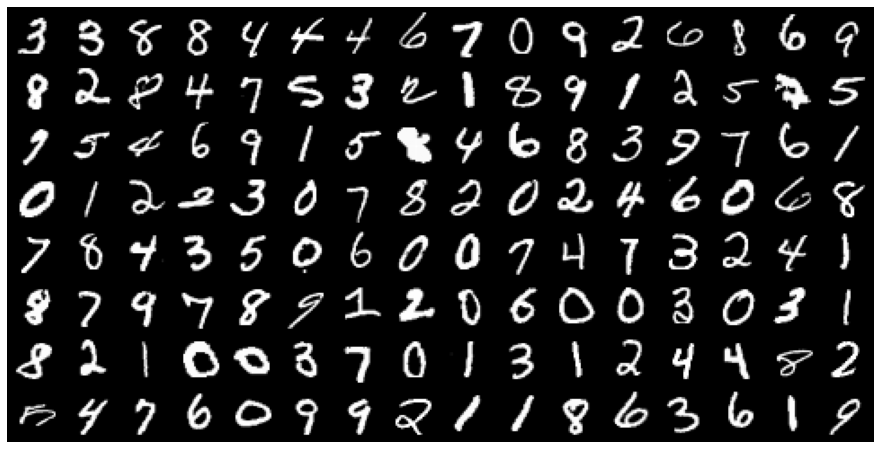

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))



In [ ]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3138742446899414
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0344, -0.0591, -0.1834,  0.1326, -0.2668, -0.0734,  0.0027,  0.1265,
          0.1873, -0.0690],
        [-0.0112, -0.0272, -0.1732, -0.0095, -0.1686, -0.1341, -0.0590,  0.0900,
          0.1752, -0.0509]])


In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
  

device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([0, 2, 2, 7, 9, 6, 1, 4, 3, 4, 3, 2, 7, 8, 4, 9, 6, 0, 4, 4, 4, 8, 4, 7,
        2, 8, 9, 4, 2, 1, 6, 2, 5, 4, 1, 0, 8, 9, 4, 2, 8, 2, 3, 3, 1, 5, 4, 1,
        4, 4, 3, 1, 4, 0, 2, 5, 8, 5, 0, 8, 1, 9, 3, 3, 5, 3, 3, 5, 7, 2, 9, 6,
        8, 3, 6, 5, 1, 9, 6, 3, 3, 9, 4, 8, 2, 9, 8, 3, 7, 4, 3, 6, 4, 5, 8, 6,
        3, 8, 3, 0, 5, 2, 0, 1, 0, 0, 9, 4, 3, 9, 7, 7, 4, 1, 7, 1, 7, 5, 6, 1,
        1, 1, 3, 2, 6, 1, 0, 6, 5, 8, 4, 6, 2, 0, 5, 7, 7, 6, 5, 1, 9, 9, 6, 7,
        8, 5, 3, 2, 9, 5, 9, 7, 0, 0, 7, 3, 4, 8, 3, 5, 3, 3, 8, 1, 8, 0, 0, 4,
        6, 7, 4, 2, 6, 7, 0, 7, 5, 6, 6, 5, 3, 8, 6, 0, 9, 2, 0, 1, 4, 0, 8, 5,
        1, 0, 8, 1, 8, 9, 9, 1, 3, 7, 9, 1, 1, 8, 7, 5, 4, 9, 3, 3, 1, 8, 7, 7,
        5, 7, 4, 6, 5, 1, 2, 7, 2, 6, 0, 4, 4, 0, 2, 4, 5, 4, 0, 4, 7, 7, 3, 3,
        9, 2, 2, 0, 4, 7, 7, 7, 3, 1, 5, 2, 7, 5, 1, 6], device='cuda:0')


In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.11552734673023224, 'val_loss': 2.315462827682495}]

In [ ]:
history += fit(7, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3247, val_acc: 0.9127
Epoch [1], val_loss: 0.3193, val_acc: 0.9135
Epoch [2], val_loss: 0.3147, val_acc: 0.9139
Epoch [3], val_loss: 0.3098, val_acc: 0.9170
Epoch [4], val_loss: 0.3059, val_acc: 0.9179
Epoch [5], val_loss: 0.3022, val_acc: 0.9193
Epoch [6], val_loss: 0.2981, val_acc: 0.9207


In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2727, val_acc: 0.9255
Epoch [1], val_loss: 0.2476, val_acc: 0.9352
Epoch [2], val_loss: 0.2329, val_acc: 0.9399
Epoch [3], val_loss: 0.2181, val_acc: 0.9444
Epoch [4], val_loss: 0.2049, val_acc: 0.9472


In [ ]:
history += fit(4, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1631, val_acc: 0.9584
Epoch [1], val_loss: 0.1772, val_acc: 0.9539
Epoch [2], val_loss: 0.1859, val_acc: 0.9492
Epoch [3], val_loss: 0.1706, val_acc: 0.9549


In [ ]:
history += fit(5, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1697, val_acc: 0.9553
Epoch [1], val_loss: 0.1690, val_acc: 0.9557
Epoch [2], val_loss: 0.1683, val_acc: 0.9555
Epoch [3], val_loss: 0.1676, val_acc: 0.9559
Epoch [4], val_loss: 0.1669, val_acc: 0.9560


In [ ]:
history += fit(5, 0.00002, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1668, val_acc: 0.9560
Epoch [1], val_loss: 0.1667, val_acc: 0.9561
Epoch [2], val_loss: 0.1666, val_acc: 0.9561
Epoch [3], val_loss: 0.1665, val_acc: 0.9561
Epoch [4], val_loss: 0.1664, val_acc: 0.9561


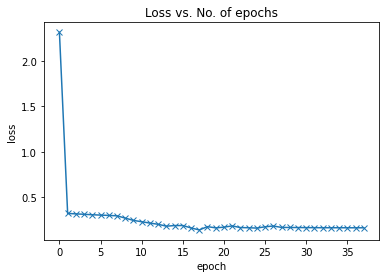

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');


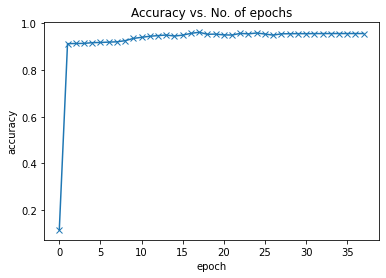

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');